# Tag Prediction

## Reading the dataset

### Importing necessary Packages and understanding the data

In [1]:
#mandatory libraries
import os
import re
import string
import numpy as np
import pandas as pd

#miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
from itertools import combinations

In [2]:
df = pd.read_csv('stackoverflow.csv', index_col = 0)

In [3]:
df

Text                Tags
2        aspnet site maps has anyone got experience cre...  ['sql', 'asp.net']
4        adding scripting functionality to net applicat...      ['c#', '.net']
5        should i use nested classes in this case i am ...             ['c++']
6        homegrown consumption of web services i have b...            ['.net']
8        automatically update version number i would li...              ['c#']
...                                                    ...                 ...
1262668  using lambda in default initializer gcc vs cla...             ['c++']
1262834  stl list very bad performance it is supposed t...             ['c++']
1262915  how to use a dict to subset a dataframe say i ...          ['python']
1263065  is there a way to use itertools in python to c...          ['python']
1263454  why does my result data returned as void gets ...             ['c++']

[48976 rows x 2 columns]

In [4]:
df.shape

(48976, 2)

# Data Preprocessing and Data Cleaning

## 1. Preprocessing the data and reducing the burden on the machine

In [5]:
#NLTK libraries  & for data cleaning

import contractions
import nltk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

In [6]:
#Using GENSIM package for data cleaning

from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric

In [7]:
def convert_to_lower_case(text):
    return text.lower()

In [8]:
def remove_escape_char(text):
    return re.sub(r"[\n\t\\\/]"," ",text, flags=re.MULTILINE)

In [9]:
#Since BeautifulSoup takes more time than regex

def remove_html_tags(text):
    return re.sub(r"<.*>"," ",text, flags=re.MULTILINE)

In [10]:
def remove_links(text):
    text= re.sub(r"http\S+"," ",text, flags=re.MULTILINE)

    return re.sub(r"www\S+"," ",text, flags=re.MULTILINE)

In [11]:
def remove_digits(text):
    return strip_numeric(text)

In [12]:
def remove_punctuation(text):
    return strip_punctuation(text)

In [13]:
def chuncking(text):
    chunks_data=[]
    chunks_data=(list(ne_chunk(pos_tag(word_tokenize(text)))))
    for label in chunks_data:
        if type(label) ==Tree:
            if label.label() == "GPE":
                a = label.leaves()
                if len(a)>1:
                    gpe = "_".join([term for term,pos in a])
                    text = re.sub(rf'{a[1][0]}',gpe,text, flags=re.MULTILINE)
                    text = re.sub(rf'\b{a[0][0]}\b'," ",text, flags=re.MULTILINE)
            if label.label()=="PERSON":      
                for term,pog in label.leaves():
                    text = re.sub(re.escape(term)," ",text, flags=re.MULTILINE)
    return text

In [14]:
def keep_alpha_and_underscore(text):    
    return re.sub(r"[^a-zA-Z_]"," ",text,flags=re.MULTILINE)

In [15]:
def remove_repeated_characters(text):
    return re.sub(r"(\w)(\1{2,})","\\1",text,flags=re.MULTILINE)

In [16]:
def decontraction(text):
    res=""
    for word in text.split():
        try:
            con_text = contractions.fix(word)
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
        
        except:
            con_text=contractions.fix(word.lower())
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
    return res.strip()

In [17]:
def remove_whitespaces(text):
    return strip_multiple_whitespaces(text)

In [18]:
stop_words=stopwords.words('english')

final_stop_words=list(STOPWORDS.union(set(stop_words)))
final_stop_words.extend(["mr","mrs","miss",
                        "one","two","three","four","five",
                        "six","seven","eight","nine","ten",
                        "us","also","dont","cant","any","can","along",
                        "among","during","anyone",
                         "a","b","c","d","e","f","g","h","i","j","k","l","m",
                         "n","o","p","q","r","s","t","u","v","w","x","y","z","hi","hello","hey","ok",
                         "okay","lol","rofl","hola","let","may","etc"])

In [19]:
lemmatiser = WordNetLemmatizer()

In [20]:
def preprocess(text):
    preprocessed_text = []
    for each_text in tqdm(text):
        result = remove_links(each_text)
        result = remove_html_tags(result)
        result = remove_escape_char(result)        
        result = remove_digits(result)
        result = decontraction(result)
        result = remove_punctuation(result)
        result = chuncking(result)
        result = convert_to_lower_case(result)
        result = ' '.join(non_stop_word for non_stop_word in result.split() if non_stop_word not in final_stop_words)
        result = keep_alpha_and_underscore(result)
        result = remove_repeated_characters(result)
        result = remove_whitespaces(result)
        result = ' '.join(lemmatiser.lemmatize(word,pos="v") for word in result.split())
        preprocessed_text.append(result.strip())
        
    return preprocessed_text

In [23]:
indices=np.random.randint(len(df['Text'].values),size=5)
indices= np.append(indices, 32449)

for i in indices:
    print(i," - Original Text ---> ",df['Text'].values[i])
    print(i," - Processed Text ---> ",preprocess([df['Text'].values[i]]))
    print("="*270)

28766  - Original Text --->  spring integration our application has been designed using spring integration framework complete message action flow starts with listening to queues for which jms message driven adapters has been used after which channel based ie queue endpoints have been defined and each endpoint is processed by serviceactivatorswe are currently into performance phase we are spawning 200 message request initially we observed that messages were not executing in parallel after doing some reading figured out that by adding concurrentconsumer and maxconcurrentconsumer property to jms message driven listener adapter will help to enable multithreading mode indeed this helped but still somewhere in between the process i still see single thread effect is this due to way the endpoint has been defined what is the advantage of adding queue capacity to each endpoint do you think by adding queuecapacity to each channel endpoint definition will again help to run in mutlithreading modeth

  0%|          | 0/1 [00:00<?, ?it/s]

28766  - Processed Text --->  ['spring integration application design use spring integration framework complete message action flow start listen queue jms message drive adapters use channel base ie queue endpoints define endpoint process serviceactivatorswe currently performance phase spawn message request initially observe message execute parallel read figure add concurrentconsumer maxconcurrentconsumer property jms message drive listener adapter help enable multithreading mode indeed help still somewhere process still see single thread effect due way endpoint define advantage add queue capacity endpoint think add queuecapacity channel endpoint definition help run mutlithreading modethe design snapshot request']
21249  - Original Text --->  android app restarts automatically after a crash my app is partly written in native app using cc the problem is that whenever cc part crashes for some reason the app dies and then restarts automatically this causes all kinds of messy problemsnow of

  0%|          | 0/1 [00:00<?, ?it/s]

21249  - Processed Text --->  ['android app restart automatically crash app partly write native app use cc problem whenever cc part crash reason app die restart automatically cause kinds messy problemsnow course crash native part try weed reason happen happen toquit gracefullyif die least try restart automaticallyi curious behaviour happen search try put follow line main activity element androidmanifestxmlandroidfinishontasklaunchtruebut automatic restore still happensanyone know happen change updatei think fundamental question isis something similar callback native crashone answer suggest handle crash signal grateful link do application module levelas stand currently crash app thisappears nothing logcat debug possible']
6277  - Original Text --->  c stl stringstream direct buffer access this should be pretty common yet i find it fascinating that i could not find any straight forward solutionbasically i read in a file over the network into a stringstream this is the declarationstdstrin

  0%|          | 0/1 [00:00<?, ?it/s]

6277  - Processed Text --->  ['stl stringstream direct buffer access pretty common yet find fascinate find straight forward solutionbasically read file network stringstream declarationstdstringstream membufstdiosin stdiosout stdiosbinarynow library want direct access read chunk memory read access function do thispose memorystream need itstr copy buffer seem unnecessary double memoryam miss something obvious maybe different stl class work bettereditapparently stringstream guarantee store continuously isif use vectorchar byte buffer']
39272  - Original Text --->  jaxb element that is both optional and nillable i have reformatted the question to hopefully make my intentions clearerarchitecturei am writing some web services that i will be publishing myself using jaxws the process we have been using for some time is to first write a schema that only defines the request and response objects this gets sent to the customer to approve the structure of the xml messages i do not want to write the

  0%|          | 0/1 [00:00<?, ?it/s]

39272  - Processed Text --->  ['jaxb element optional nillable reformatted question hopefully make intentions clearerarchitecturei write web service publish use jaxws process use time first write schema define request response object get send customer approve structure xml message want write whole wsdl complicate basic schemanext use jaxb command xjc generate class base request response type schema use class parameters return type jaxws annotate endpoint classthis give web service call give control xml send return automate repetition require write full wsdlproblemin schema element thisxselement namemyelement typexsstring nillabletrue minoccurs want thistinguish user set null blank generate class attributexmlelementrefname myelement namespace mynamespace type jaxbelementclassprotected jaxbelementstring myelementthe effect element become neither nillable optional schema jaxws write part wsdl set element mandatory nillable turn schema validation still pass nil object things triedif change

  0%|          | 0/1 [00:00<?, ?it/s]

45391  - Processed Text --->  ['stdstringstream str method notice something try use stringstream object useless example explain thisstringstream ss ss string cout str endl equivalent tocout stringstream stringstr endl lead compilation error complain aclass stdbasic ostreama member name astrai easily explain critical application pretty sure hide trick interest understoodnote use gcc']
32449  - Original Text --->  custom list items not responding to state checked in selector i am going to begin by saying that i have read in detail almost every question on so that i can find related to custom checkable list items and selectors many of them have similar issues but none of the answers solve my problemat a point in my app i present a custom list activity when created it retrieves a set of static data from the intent that called it and passes that data to it is custom array adapter each list item is a simple relativelayout that implements the checkable interface by default if you click on one

  0%|          | 0/1 [00:00<?, ?it/s]

32449  - Processed Text --->  ['custom list items respond state check selector go begin say read detail almost every question find relate custom checkable list items selectors many similar issue none answer solve problemat point app present custom list activity create retrieve set static data intent call pass data custom array adapter list item simple relativelayout implement checkable interface default click items new activity show thisplays detail information select contact item list longclicked actionmode start click item list point thisplay detail activity set item check user choose action mode items perform action check itemsan important thing understand selection modes click list item set checkedall describe work perfectly problem background list items highlight set check even use default selectorwhat want selectors selection mode first background change item check second try implement custom selectors even state check ignore part selector work fine state check implementation che

In [24]:
preprocessed_data = preprocess(df['Text'].values)

  0%|          | 0/48976 [00:00<?, ?it/s]

In [25]:
# clean_data = df.set_index(keys="id", drop = True)
df['Text'] = preprocessed_data
df.sample(5)

Text  \
704526   declare byte array scala scala declare byte ar...   
50070    iphone catransition add fade start end animati...   
433327   add custom view map annotations callouts code ...   
1076852  change bootstrap radio click sure try quite si...   
119913   shortest way compare ienumerable items possibl...   

                                            Tags  
704526                                  ['java']  
50070                                 ['iphone']  
433327                                ['iphone']  
1076852  ['javascript', 'jquery', 'html', 'css']  
119913                                    ['c#']

In [26]:
df.to_csv("cleaned_data_stackoverflow.csv", index = False)

In [27]:
df

Text                Tags
2        aspnet site map get experience create sqlbased...  ['sql', 'asp.net']
4        add script functionality net applications litt...      ['c#', '.net']
5        use nest class case work collection class use ...             ['c++']
6        homegrown consumption web service write web se...            ['.net']
8        automatically update version number version pr...              ['c#']
...                                                    ...                 ...
1262668  use lambda default initializer gcc vs clang in...             ['c++']
1262834  stl list bad performance suppose push back pop...             ['c++']
1262915  use dict subset dataframe say give dataframe c...          ['python']
1263065  way use itertools python clean nest iterations...          ['python']
1263454  result data return void get break work project...             ['c++']

[48976 rows x 2 columns]

## 2. Cleaning the noisy data after the preprocessing methods

In [28]:
clean_data = pd.read_csv("cleaned_data_stackoverflow.csv")

In [29]:
clean_data

Text                Tags
0      aspnet site map get experience create sqlbased...  ['sql', 'asp.net']
1      add script functionality net applications litt...      ['c#', '.net']
2      use nest class case work collection class use ...             ['c++']
3      homegrown consumption web service write web se...            ['.net']
4      automatically update version number version pr...              ['c#']
...                                                  ...                 ...
48971  use lambda default initializer gcc vs clang in...             ['c++']
48972  stl list bad performance suppose push back pop...             ['c++']
48973  use dict subset dataframe say give dataframe c...          ['python']
48974  way use itertools python clean nest iterations...          ['python']
48975  result data return void get break work project...             ['c++']

[48976 rows x 2 columns]

In [30]:
clean_data.isnull().values.any()

False

In [33]:
clean_data.dropna(inplace=True)

In [34]:
clean_data.isnull().values.any()

False

In [35]:
clean_data.head()

Text                Tags
0  aspnet site map get experience create sqlbased...  ['sql', 'asp.net']
1  add script functionality net applications litt...      ['c#', '.net']
2  use nest class case work collection class use ...             ['c++']
3  homegrown consumption web service write web se...            ['.net']
4  automatically update version number version pr...              ['c#']

In [36]:
clean_data

Text                Tags
0      aspnet site map get experience create sqlbased...  ['sql', 'asp.net']
1      add script functionality net applications litt...      ['c#', '.net']
2      use nest class case work collection class use ...             ['c++']
3      homegrown consumption web service write web se...            ['.net']
4      automatically update version number version pr...              ['c#']
...                                                  ...                 ...
48971  use lambda default initializer gcc vs clang in...             ['c++']
48972  stl list bad performance suppose push back pop...             ['c++']
48973  use dict subset dataframe say give dataframe c...          ['python']
48974  way use itertools python clean nest iterations...          ['python']
48975  result data return void get break work project...             ['c++']

[48976 rows x 2 columns]

In [37]:
clean_data.to_csv("cleaned_data_stackoverflow_final.csv", index = False)

# Sepearating the tags

In [38]:
df1 = pd.read_csv("cleaned_data_stackoverflow_final.csv")

In [39]:
df1

Text                Tags
0      aspnet site map get experience create sqlbased...  ['sql', 'asp.net']
1      add script functionality net applications litt...      ['c#', '.net']
2      use nest class case work collection class use ...             ['c++']
3      homegrown consumption web service write web se...            ['.net']
4      automatically update version number version pr...              ['c#']
...                                                  ...                 ...
48971  use lambda default initializer gcc vs clang in...             ['c++']
48972  stl list bad performance suppose push back pop...             ['c++']
48973  use dict subset dataframe say give dataframe c...          ['python']
48974  way use itertools python clean nest iterations...          ['python']
48975  result data return void get break work project...             ['c++']

[48976 rows x 2 columns]

In [40]:
type(df1.iloc[0]['Tags'])

str

In [41]:
#sk-learn libraries for regression and OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [42]:
import ast

In [43]:
df1.iloc[0]['Tags']

"['sql', 'asp.net']"

In [44]:
ast.literal_eval(df1.iloc[0]['Tags'])

['sql', 'asp.net']

In [45]:
df1['Tags'] = df1['Tags'].apply(lambda x: ast.literal_eval(x))

In [46]:
df1.iloc[0]['Tags']

['sql', 'asp.net']

In [47]:
df1.head()

Text            Tags
0  aspnet site map get experience create sqlbased...  [sql, asp.net]
1  add script functionality net applications litt...      [c#, .net]
2  use nest class case work collection class use ...           [c++]
3  homegrown consumption web service write web se...          [.net]
4  automatically update version number version pr...            [c#]

In [49]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df1['Tags'])

In [50]:
y.shape

(48976, 20)

In [51]:
classes = multilabel.classes_

In [52]:
classes

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql',
       'objective-c', 'php', 'python', 'ruby', 'ruby-on-rails', 'sql'],
      dtype=object)

In [53]:
pd.DataFrame(y, columns=classes)

.net  android  asp.net  c  c#  c++  css  html  ios  iphone  java  \
0         0        0        1  0   0    0    0     0    0       0     0   
1         1        0        0  0   1    0    0     0    0       0     0   
2         0        0        0  0   0    1    0     0    0       0     0   
3         1        0        0  0   0    0    0     0    0       0     0   
4         0        0        0  0   1    0    0     0    0       0     0   
...     ...      ...      ... ..  ..  ...  ...   ...  ...     ...   ...   
48971     0        0        0  0   0    1    0     0    0       0     0   
48972     0        0        0  0   0    1    0     0    0       0     0   
48973     0        0        0  0   0    0    0     0    0       0     0   
48974     0        0        0  0   0    0    0     0    0       0     0   
48975     0        0        0  0   0    1    0     0    0       0     0   

       javascript  jquery  mysql  objective-c  php  python  ruby  \
0               0       0      0            0    0       0     0   
1               0       0      0            0    0       0     0   
2               0       0      0            0    0       0     0   
3               0       0      0            0    0       0     0   
4               0       0      0            0    0       0     0   
...           ...     ...    ...          ...  ...     ...   ...   
48971           0       0      0            0    0       0     0   
48972           0       0      0            0    0       0     0   
48973           0       0      0            0    0       1     0   
48974           0       0      0            0    0       1     0   
48975           0       0      0            0    0       0     0   

       ruby-on-rails  sql  
0                  0    1  
1                  0    0  
2                  0    0  
3                  0    0  
4                  0    0  
...              ...  ...  
48971              0    0  
48972              0    0  
48973              0    0  
48974              0    0  
48975              0    0  

[48976 rows x 20 columns]

In [54]:
df_final = df1.join(pd.DataFrame(y, columns=classes))

In [56]:
df_final.to_csv("stackoverflow_final_model.csv", index = False)

In [57]:
df_final

Text            Tags  \
0      aspnet site map get experience create sqlbased...  [sql, asp.net]   
1      add script functionality net applications litt...      [c#, .net]   
2      use nest class case work collection class use ...           [c++]   
3      homegrown consumption web service write web se...          [.net]   
4      automatically update version number version pr...            [c#]   
...                                                  ...             ...   
48971  use lambda default initializer gcc vs clang in...           [c++]   
48972  stl list bad performance suppose push back pop...           [c++]   
48973  use dict subset dataframe say give dataframe c...        [python]   
48974  way use itertools python clean nest iterations...        [python]   
48975  result data return void get break work project...           [c++]   

       .net  android  asp.net  c  c#  c++  css  html  ...  java  javascript  \
0         0        0        1  0   0    0    0     0  ...     0           0   
1         1        0        0  0   1    0    0     0  ...     0           0   
2         0        0        0  0   0    1    0     0  ...     0           0   
3         1        0        0  0   0    0    0     0  ...     0           0   
4         0        0        0  0   1    0    0     0  ...     0           0   
...     ...      ...      ... ..  ..  ...  ...   ...  ...   ...         ...   
48971     0        0        0  0   0    1    0     0  ...     0           0   
48972     0        0        0  0   0    1    0     0  ...     0           0   
48973     0        0        0  0   0    0    0     0  ...     0           0   
48974     0        0        0  0   0    0    0     0  ...     0           0   
48975     0        0        0  0   0    1    0     0  ...     0           0   

       jquery  mysql  objective-c  php  python  ruby  ruby-on-rails  sql  
0           0      0            0    0       0     0              0    1  
1           0      0            0    0       0     0              0    0  
2           0      0            0    0       0     0              0    0  
3           0      0            0    0       0     0              0    0  
4           0      0            0    0       0     0              0    0  
...       ...    ...          ...  ...     ...   ...            ...  ...  
48971       0      0            0    0       0     0              0    0  
48972       0      0            0    0       0     0              0    0  
48973       0      0            0    0       1     0              0    0  
48974       0      0            0    0       1     0              0    0  
48975       0      0            0    0       0     0              0    0  

[48976 rows x 22 columns]

In [58]:
tags_class = ['.net', 'android', 'asp.net', 'c', 'c#','c++', 'css', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql', 'objective-c','php', 'python', 'ruby', 'ruby-on-rails', 'sql']

# EDA - Exploratory Data Analysis

## Importing the packages

In [59]:
#plotting libraries
import venn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly as py
import cufflinks as cf
import matplotlib

<AxesSubplot:>

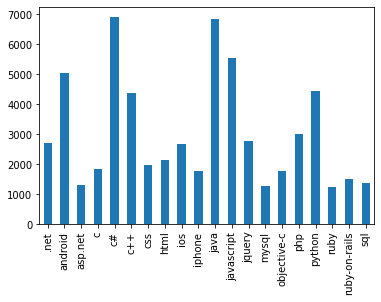

In [60]:
df_final[tags_class].sum().plot.bar()

In [61]:
def null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('%d%% or %d missing from %s column.' % 
          (perc, nans, df_name))

def check_null(df, columns):
    for col in columns:
        null_percentage(df[col])
        
check_null(df_final, df_final.columns)

0% or 0 missing from Text column.
0% or 0 missing from Tags column.
0% or 0 missing from .net column.
0% or 0 missing from android column.
0% or 0 missing from asp.net column.
0% or 0 missing from c column.
0% or 0 missing from c# column.
0% or 0 missing from c++ column.
0% or 0 missing from css column.
0% or 0 missing from html column.
0% or 0 missing from ios column.
0% or 0 missing from iphone column.
0% or 0 missing from java column.
0% or 0 missing from javascript column.
0% or 0 missing from jquery column.
0% or 0 missing from mysql column.
0% or 0 missing from objective-c column.
0% or 0 missing from php column.
0% or 0 missing from python column.
0% or 0 missing from ruby column.
0% or 0 missing from ruby-on-rails column.
0% or 0 missing from sql column.


In [62]:
print('%d features and %d records.' % (df_final.shape[1], df_final.shape[0]))

22 features and 48976 records.


In [63]:
print('%d features and %d records.' % (df_final.shape[1], df_final.shape[0]))
print()
targets = list(df_final.columns[2:])
print('Target columns: ' + ', '.join(targets))

22 features and 48976 records.

Target columns: .net, android, asp.net, c, c#, c++, css, html, ios, iphone, java, javascript, jquery, mysql, objective-c, php, python, ruby, ruby-on-rails, sql


In [64]:
df_classes = df_final[list(df_final.columns[2:])].copy()

# How many rows are toxic? 
res = df_classes.sum(axis=1)
res = (res > 0)

# Create overall any_label feature
# targets.append('at_least_one')
# df_classes['at_least_one'] = res

In [65]:
targets

['.net',
 'android',
 'asp.net',
 'c',
 'c#',
 'c++',
 'css',
 'html',
 'ios',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'mysql',
 'objective-c',
 'php',
 'python',
 'ruby',
 'ruby-on-rails',
 'sql']

In [66]:
count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_classes[(df_classes[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts

### 1. Understanding the tags

In [67]:
del(df_selection)

print('Training Data Comment Breakdown')
print('%d out of %d comments, or %.2f%%, are classified as some tag.' % 
     (np.sum(res), len(df_final), (np.sum(res)/len(df_final))*100))

Training Data Comment Breakdown
48976 out of 48976 comments, or 100.00%, are classified as some tag.


In [68]:
totals = []
for key, value in count_dic.items():
    totals.append(value[0][1])
    print('\n%d %s comments. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(df_final))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))


2705 .net comments. (5.52% of all data.)
- 5 or 0.18% were also android.
- 149 or 5.51% were also asp.net.
- 6 or 0.22% were also c.
- 1747 or 64.58% were also c#.
- 14 or 0.52% were also c++.
- 1 or 0.04% were also css.
- 5 or 0.18% were also html.
- 1 or 0.04% were also ios.
- 2 or 0.07% were also iphone.
- 24 or 0.89% were also java.
- 11 or 0.41% were also javascript.
- 4 or 0.15% were also jquery.
- 3 or 0.11% were also mysql.
- 2 or 0.07% were also objective-c.
- 5 or 0.18% were also php.
- 2 or 0.07% were also python.
- 1 or 0.04% were also ruby.
- 0 or 0.00% were also ruby-on-rails.
- 18 or 0.67% were also sql.

5052 android comments. (10.32% of all data.)
- 5 or 0.10% were also .net.
- 1 or 0.02% were also asp.net.
- 9 or 0.18% were also c.
- 15 or 0.30% were also c#.
- 13 or 0.26% were also c++.
- 15 or 0.30% were also css.
- 24 or 0.48% were also html.
- 58 or 1.15% were also ios.
- 28 or 0.55% were also iphone.
- 583 or 11.54% were also java.
- 61 or 1.21% were also javasc

### 2. Sum of number of tags present

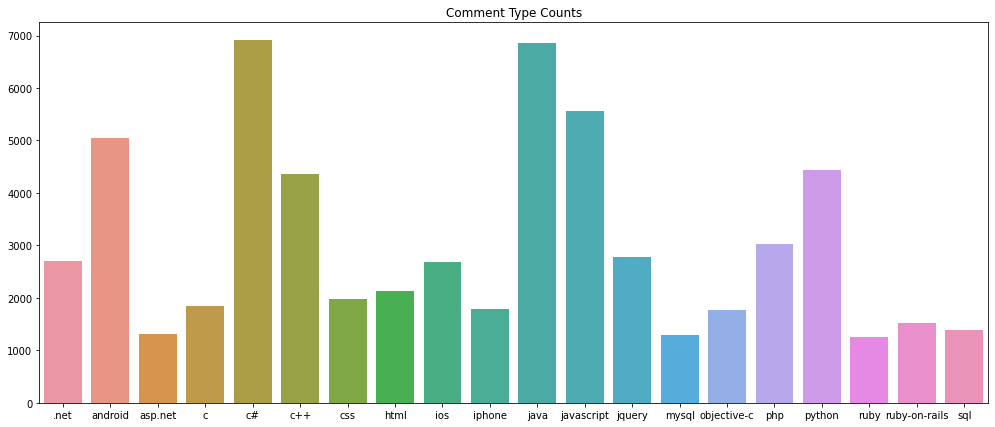

In [69]:
plt.figure('Comment Type Counts', figsize=[17,7])
plt.title('Comment Type Counts')
sns.barplot(x = list(count_dic.keys()), y = totals)
plt.show()

### 3. Heatmap

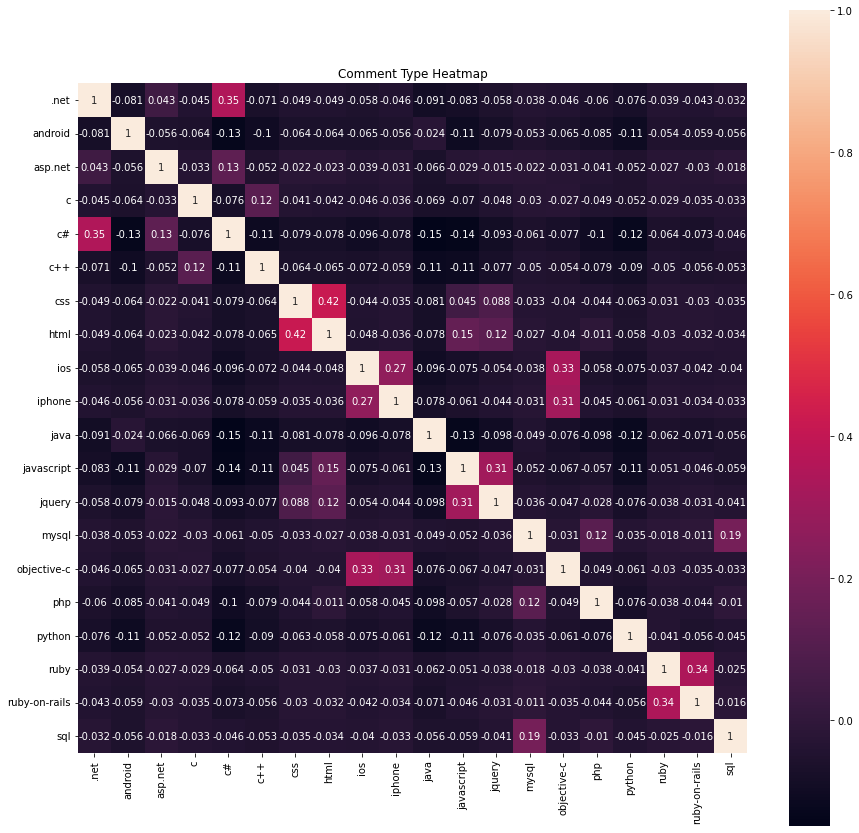

In [70]:
def heatmap(df, title):
    plt.figure('heatmap', figsize=[15, 15])
    plt.title(title)
    df_corr = df.corr()
    sns.heatmap(df_corr, square=True, annot=True)
    plt.show()

heatmap(df_classes, 'Comment Type Heatmap')

In [71]:
from textblob import TextBlob
import plotly as py
import cufflinks as cf
from sklearn.feature_extraction.text import CountVectorizer

py.offline.init_notebook_mode(connected=True)
cf.go_offline()

In [72]:
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(1,1), stop_words = 'english').fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
    return words_freq[:n]

In [73]:
df_final

Text            Tags  \
0      aspnet site map get experience create sqlbased...  [sql, asp.net]   
1      add script functionality net applications litt...      [c#, .net]   
2      use nest class case work collection class use ...           [c++]   
3      homegrown consumption web service write web se...          [.net]   
4      automatically update version number version pr...            [c#]   
...                                                  ...             ...   
48971  use lambda default initializer gcc vs clang in...           [c++]   
48972  stl list bad performance suppose push back pop...           [c++]   
48973  use dict subset dataframe say give dataframe c...        [python]   
48974  way use itertools python clean nest iterations...        [python]   
48975  result data return void get break work project...           [c++]   

       .net  android  asp.net  c  c#  c++  css  html  ...  java  javascript  \
0         0        0        1  0   0    0    0     0  ...     0           0   
1         1        0        0  0   1    0    0     0  ...     0           0   
2         0        0        0  0   0    1    0     0  ...     0           0   
3         1        0        0  0   0    0    0     0  ...     0           0   
4         0        0        0  0   1    0    0     0  ...     0           0   
...     ...      ...      ... ..  ..  ...  ...   ...  ...   ...         ...   
48971     0        0        0  0   0    1    0     0  ...     0           0   
48972     0        0        0  0   0    1    0     0  ...     0           0   
48973     0        0        0  0   0    0    0     0  ...     0           0   
48974     0        0        0  0   0    0    0     0  ...     0           0   
48975     0        0        0  0   0    1    0     0  ...     0           0   

       jquery  mysql  objective-c  php  python  ruby  ruby-on-rails  sql  
0           0      0            0    0       0     0              0    1  
1           0      0            0    0       0     0              0    0  
2           0      0            0    0       0     0              0    0  
3           0      0            0    0       0     0              0    0  
4           0      0            0    0       0     0              0    0  
...       ...    ...          ...  ...     ...   ...            ...  ...  
48971       0      0            0    0       0     0              0    0  
48972       0      0            0    0       0     0              0    0  
48973       0      0            0    0       1     0              0    0  
48974       0      0            0    0       1     0              0    0  
48975       0      0            0    0       0     0              0    0  

[48976 rows x 22 columns]

In [76]:
def find_graph(s, title):
    df_m = df_final[df_final[s] == 1]
    words = get_top_n_words(df_m['Text'], 10)
    df_1 = pd.DataFrame(words, columns = ['Unigram', 'Frequency'])
    df_1 = df_1.set_index('Unigram')
    return df_1.iplot(kind = 'bar', xTitle = 'Unigram', yTitle = 'Count', title = title)

### 3. Example of the top "n" words used for a tag

In [225]:
print("Example")
find_graph('.net', 'Top 10 words for .net' )

# for i in targets:
#     find_graph(i, 'Top 10 words for ' + i)

Example


In [78]:
df_final['Text_len'] = df_final['Text'].apply(lambda x : len(x))

In [79]:
df_final

Text            Tags  \
0      aspnet site map get experience create sqlbased...  [sql, asp.net]   
1      add script functionality net applications litt...      [c#, .net]   
2      use nest class case work collection class use ...           [c++]   
3      homegrown consumption web service write web se...          [.net]   
4      automatically update version number version pr...            [c#]   
...                                                  ...             ...   
48971  use lambda default initializer gcc vs clang in...           [c++]   
48972  stl list bad performance suppose push back pop...           [c++]   
48973  use dict subset dataframe say give dataframe c...        [python]   
48974  way use itertools python clean nest iterations...        [python]   
48975  result data return void get break work project...           [c++]   

       .net  android  asp.net  c  c#  c++  css  html  ...  javascript  jquery  \
0         0        0        1  0   0    0    0     0  ...           0       0   
1         1        0        0  0   1    0    0     0  ...           0       0   
2         0        0        0  0   0    1    0     0  ...           0       0   
3         1        0        0  0   0    0    0     0  ...           0       0   
4         0        0        0  0   1    0    0     0  ...           0       0   
...     ...      ...      ... ..  ..  ...  ...   ...  ...         ...     ...   
48971     0        0        0  0   0    1    0     0  ...           0       0   
48972     0        0        0  0   0    1    0     0  ...           0       0   
48973     0        0        0  0   0    0    0     0  ...           0       0   
48974     0        0        0  0   0    0    0     0  ...           0       0   
48975     0        0        0  0   0    1    0     0  ...           0       0   

       mysql  objective-c  php  python  ruby  ruby-on-rails  sql  Text_len  
0          0            0    0       0     0              0    1       265  
1          0            0    0       0     0              0    0       683  
2          0            0    0       0     0              0    0       541  
3          0            0    0       0     0              0    0       208  
4          0            0    0       0     0              0    0       475  
...      ...          ...  ...     ...   ...            ...  ...       ...  
48971      0            0    0       0     0              0    0       374  
48972      0            0    0       0     0              0    0      2052  
48973      0            0    0       1     0              0    0       686  
48974      0            0    0       1     0              0    0       121  
48975      0            0    0       0     0              0    0      1226  

[48976 rows x 23 columns]

In [226]:
for t in targets:
    print("#################################","Class: %s" % t, "#################################")
    b = np.where(df_classes[t]==1)[0]
    selection = np.random.choice(b, 5)
    i = 1
    for s in selection:
        print(i, ".", df_final.Text.iloc[s])
        i+=1
        print("------------")
    print()

################################# Class: .net #################################
1 . linqpad mongodb possible use linqpad mongodb tool matter allow use linq run adhoc query mongoi try use write query json bracket quote colons drive absolutely insane tool go resort write query compilingrunning
------------
2 . set largeaddressaware within visual studio net assembly need bite need largeaddressawarei know editbin wonder builtin way visual studio alternatively someone write msbuild task thisedit app linker options sadly
------------
3 . move visual studio net currently use vs profesional net project rather large project solution try vs theoretically faster larger project thing know read true use vs net mode want customers install net want install vs open solution start work possiblepd solution window form project
------------
4 . web base codereview tool team foundation server team look start utilize code review tool use many past fond options available svn use team foundation server source

### 3. Venn Diagrams

In [82]:
import venn

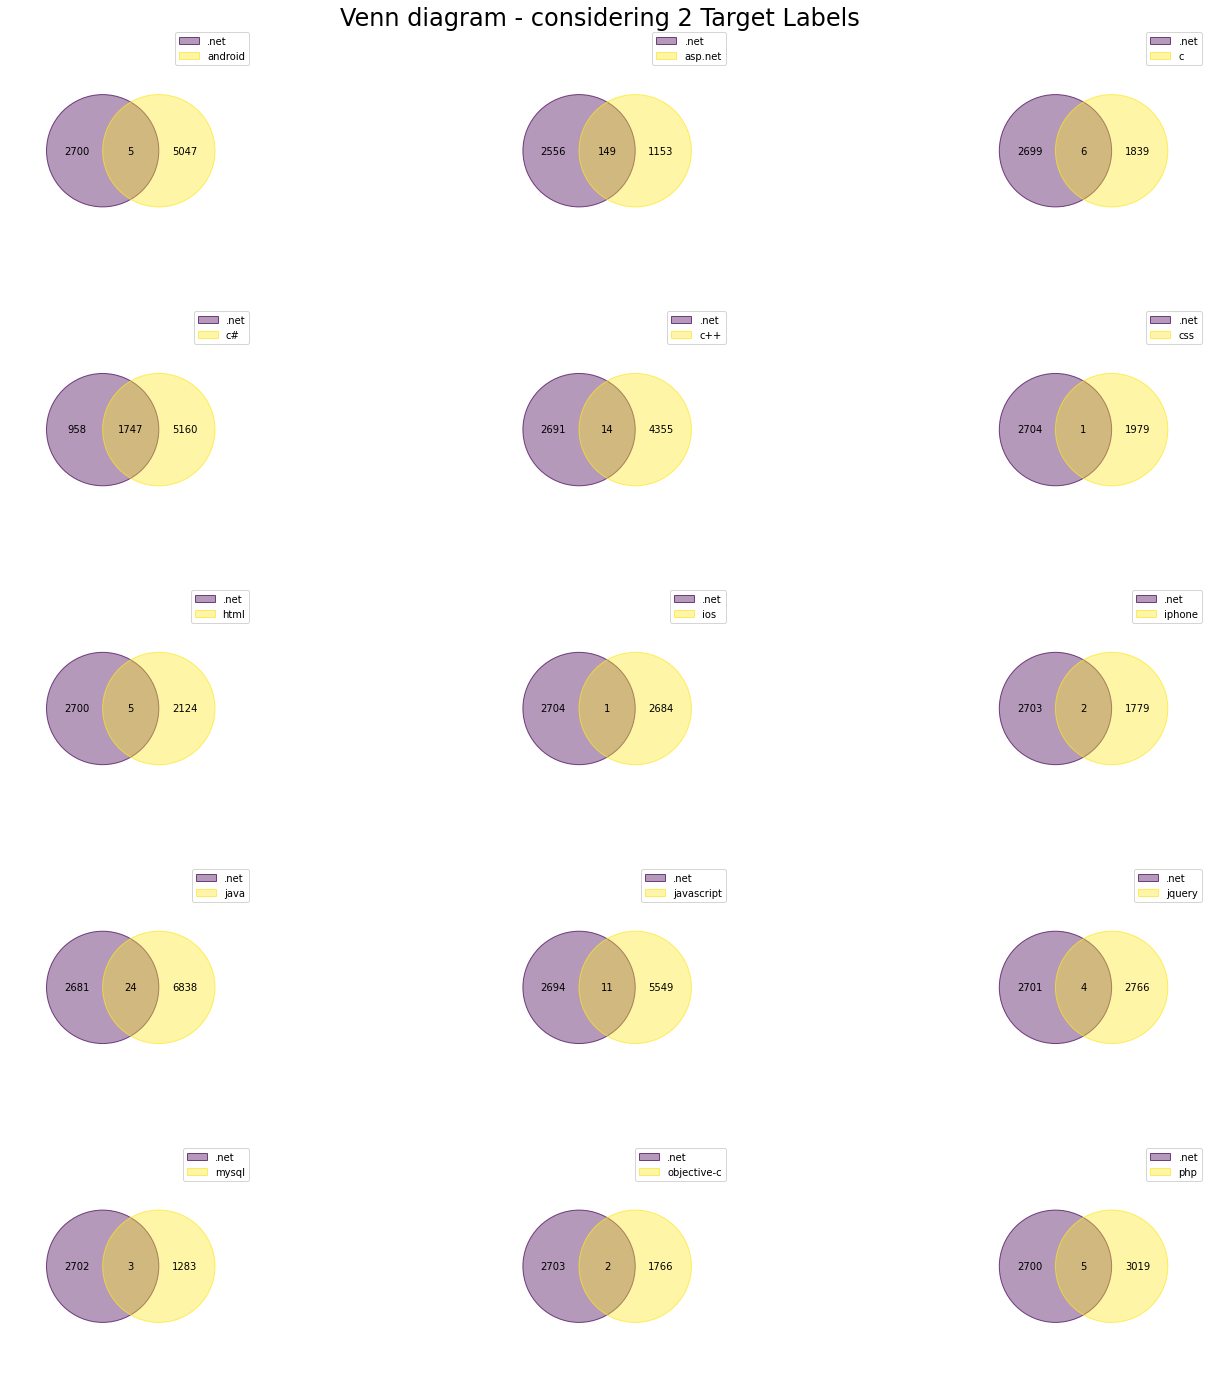

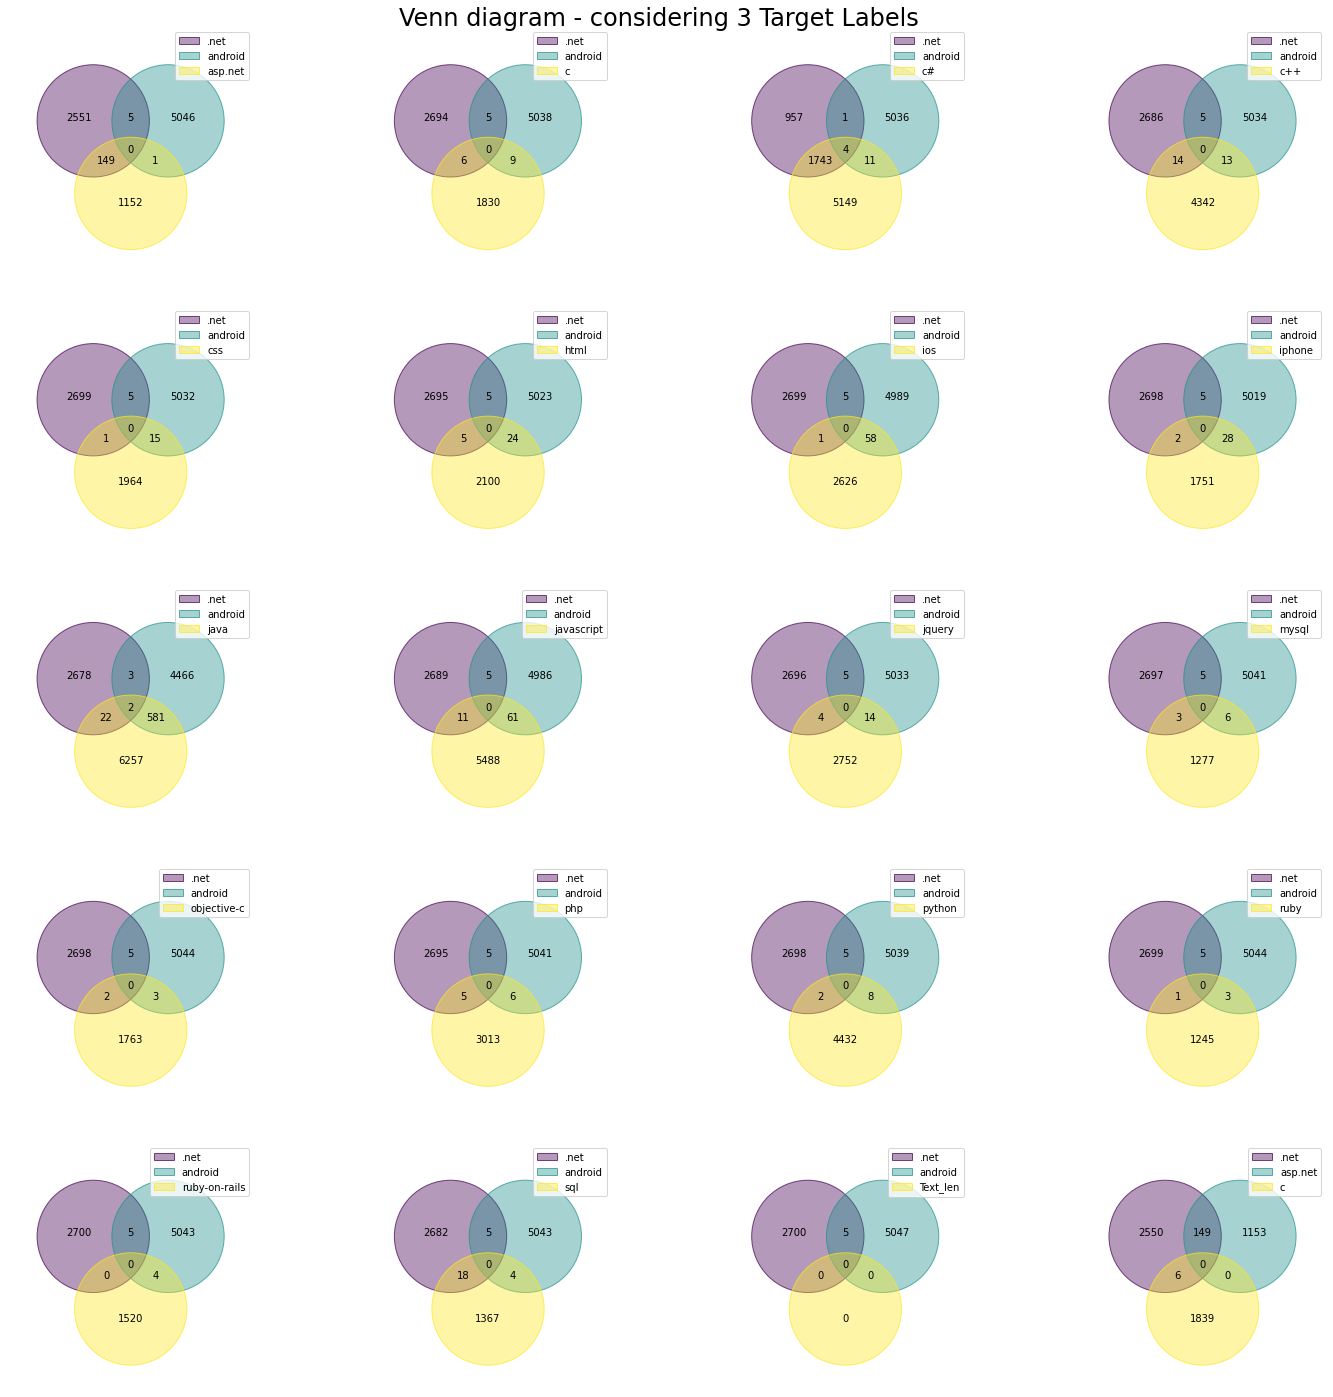

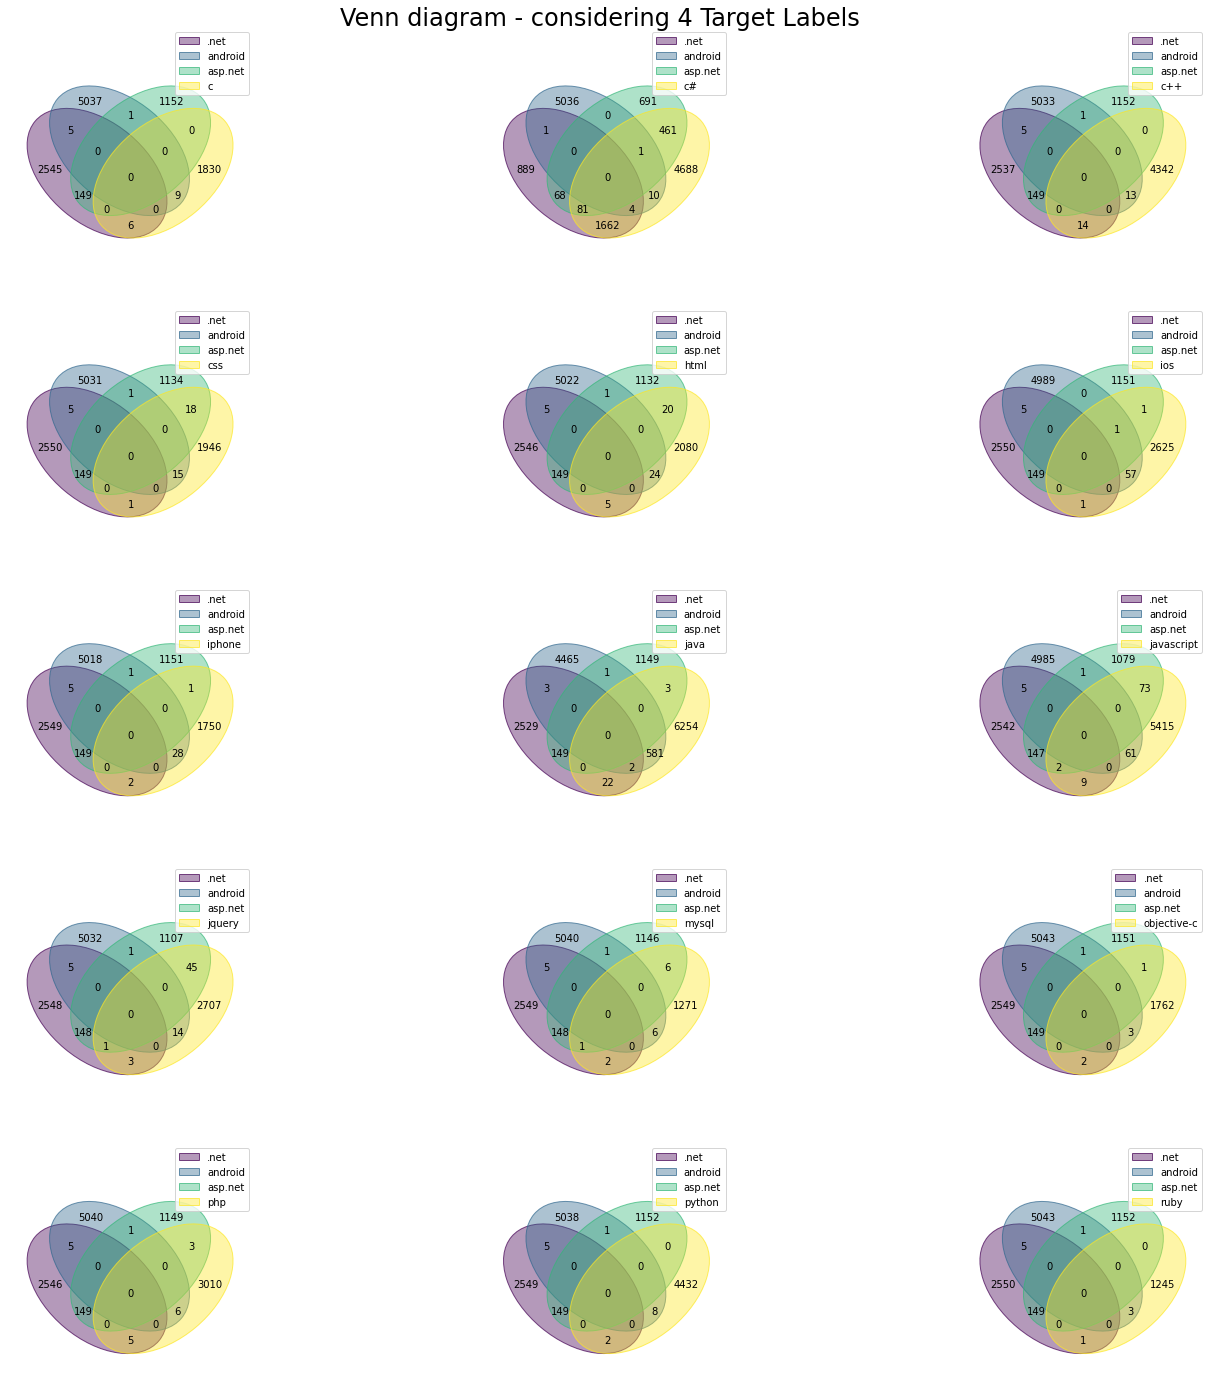

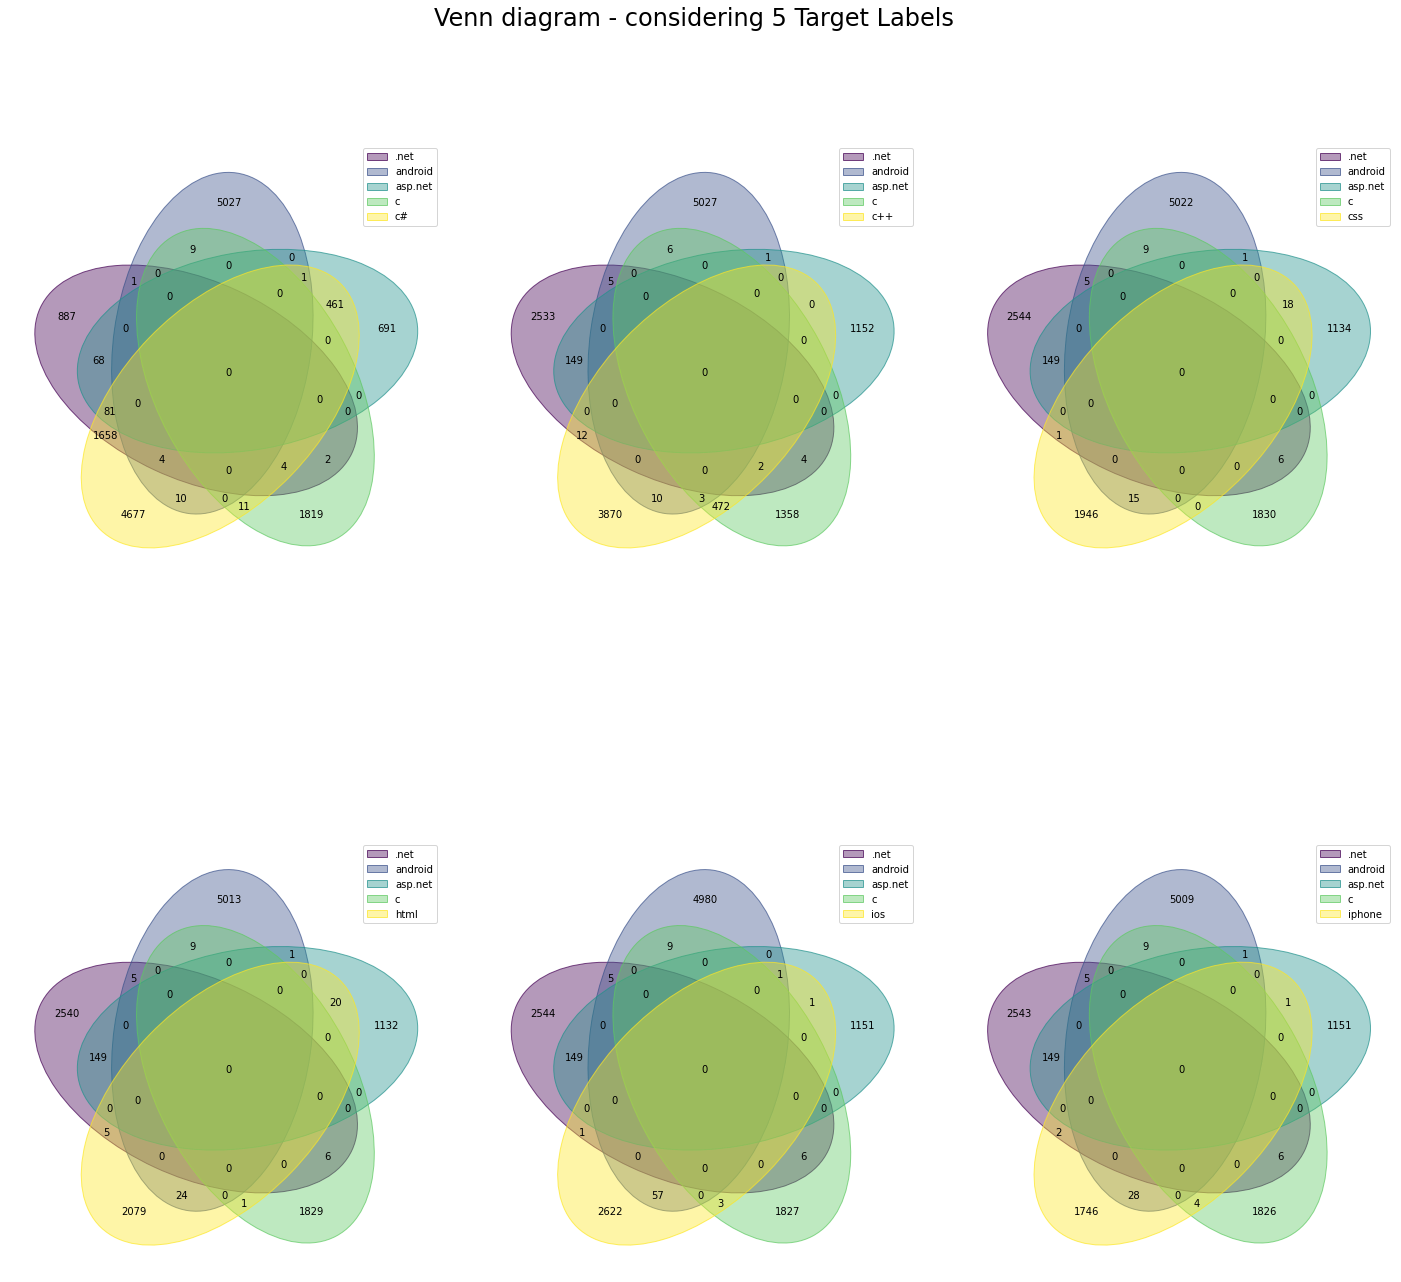

In [84]:
no_of_labels = np.arange(2,20)
rows_col=[(5,3),(5,4),(5,3),(2,3)]


for i,rc in zip(no_of_labels,rows_col):
    comb = combinations(df_final.columns.values[2:], i)
    fig, top_axs = plt.subplots(ncols=rc[1], nrows=rc[0],figsize=(20, 20))
    fig.suptitle("Venn diagram - considering "+str(i)+" Target Labels",fontsize=24)
    fig.subplots_adjust(top=0.88)
    fig.tight_layout()
    top_axs=top_axs.flatten()
    for j,ax in zip(list(comb),top_axs):
        data_set=dict()
        for k in j:
            data_set[k]=set(df_final[(df_final[k]==1)].index)
        venn_dgrm=venn.venn(data_set,legend_loc="best",alpha=0.4,fontsize=10,ax=ax)

# TF-IDF

##### We use TFIDF vector for converting words to numerics, and hence comparing it with the sentiments of the comment or the labels of the labels of the comment_text.

In [85]:
#sk-learn libraries for vectorization

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [86]:
try_tfidf = pd.read_csv("stackoverflow_final_model.csv")

In [87]:
try_tfidf

Text                Tags  \
0      aspnet site map get experience create sqlbased...  ['sql', 'asp.net']   
1      add script functionality net applications litt...      ['c#', '.net']   
2      use nest class case work collection class use ...             ['c++']   
3      homegrown consumption web service write web se...            ['.net']   
4      automatically update version number version pr...              ['c#']   
...                                                  ...                 ...   
48971  use lambda default initializer gcc vs clang in...             ['c++']   
48972  stl list bad performance suppose push back pop...             ['c++']   
48973  use dict subset dataframe say give dataframe c...          ['python']   
48974  way use itertools python clean nest iterations...          ['python']   
48975  result data return void get break work project...             ['c++']   

       .net  android  asp.net  c  c#  c++  css  html  ...  java  javascript  \
0         0        0        1  0   0    0    0     0  ...     0           0   
1         1        0        0  0   1    0    0     0  ...     0           0   
2         0        0        0  0   0    1    0     0  ...     0           0   
3         1        0        0  0   0    0    0     0  ...     0           0   
4         0        0        0  0   1    0    0     0  ...     0           0   
...     ...      ...      ... ..  ..  ...  ...   ...  ...   ...         ...   
48971     0        0        0  0   0    1    0     0  ...     0           0   
48972     0        0        0  0   0    1    0     0  ...     0           0   
48973     0        0        0  0   0    0    0     0  ...     0           0   
48974     0        0        0  0   0    0    0     0  ...     0           0   
48975     0        0        0  0   0    1    0     0  ...     0           0   

       jquery  mysql  objective-c  php  python  ruby  ruby-on-rails  sql  
0           0      0            0    0       0     0              0    1  
1           0      0            0    0       0     0              0    0  
2           0      0            0    0       0     0              0    0  
3           0      0            0    0       0     0              0    0  
4           0      0            0    0       0     0              0    0  
...       ...    ...          ...  ...     ...   ...            ...  ...  
48971       0      0            0    0       0     0              0    0  
48972       0      0            0    0       0     0              0    0  
48973       0      0            0    0       1     0              0    0  
48974       0      0            0    0       1     0              0    0  
48975       0      0            0    0       0     0              0    0  

[48976 rows x 22 columns]

In [88]:
train, test = train_test_split(try_tfidf, random_state=42, test_size=0.30, shuffle=True)

In [90]:
train_text = train['Text']
test_text = test['Text']

In [91]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [92]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['Text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['Text'], axis=1)

In [95]:
categories = list(try_tfidf.columns.values)
categories = categories[2:]

In [96]:
categories

['.net',
 'android',
 'asp.net',
 'c',
 'c#',
 'c++',
 'css',
 'html',
 'ios',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'mysql',
 'objective-c',
 'php',
 'python',
 'ruby',
 'ruby-on-rails',
 'sql']

In [97]:
#metrics
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

#modelling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [98]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None), n_jobs=-1)),])

print("================= Using MultiNomial Naive Bayes =================")
i = 1
for category in categories:
    print('*', i, 'Processing {} comments...'.format(category))
    i+=1
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print()


LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])

print("================= Using Linear SVC =================")
i = 1
for category in categories:
    print('*',i, 'Processing {} comments...'.format(category))
    i+=1
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print()
    
    
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])

print("================= Using Logistic Regression =================")
i = 1
for category in categories:
    print('*',i, 'Processing {} comments...'.format(category))
    i+=1
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print()

================= Using MultiNomial Naive Bayes =================
* 1 Processing .net comments...
Test accuracy is 0.944327230654053

* 2 Processing android comments...
Test accuracy is 0.9004287756074321

* 3 Processing asp.net comments...
Test accuracy is 0.9729803307697543

* 4 Processing c comments...
Test accuracy is 0.9647451167222487

* 5 Processing c# comments...
Test accuracy is 0.8634724018239979

* 6 Processing c++ comments...
Test accuracy is 0.9119989110460763

* 7 Processing css comments...
Test accuracy is 0.959708704825427

* 8 Processing html comments...
Test accuracy is 0.9546722929286054

* 9 Processing ios comments...
Test accuracy is 0.9424896209079153

* 10 Processing iphone comments...
Test accuracy is 0.9642686993806574

* 11 Processing java comments...
Test accuracy is 0.8617028516980876

* 12 Processing javascript comments...
Test accuracy is 0.8898114748519703

* 13 Processing jquery comments...
Test accuracy is 0.9450758864765535

* 14 Processing mysql comme

In [104]:
print("initialize classifier chains multi-label classifier")
# classifier = ClassifierChain(LogisticRegression())

print("Training logistic regression model on train data")
# classifier.fit(x_train, y_train)

print("predict")
# predictions = classifier.predict(x_test)

print("accuracy")
# print("Accuracy = ",accuracy_score(y_test,predictions))

initialize classifier chains multi-label classifier
Training logistic regression model on train data
predict
accuracy


##### We cannot use the simple TD-IDF Function since, it the space - time complexity increases. Hence, we have to use GloVe

## With GloVe

In [105]:
#multi-processing
import multiprocessing
from multiprocessing import Process

#multi-label 
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

#metrics
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

#modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [110]:
clean_data=pd.read_csv("stackoverflow_final_model.csv")

In [111]:
clean_data.shape

(48976, 22)

In [112]:
clean_data.sample(3)

Text                Tags  \
10342  query record base radius sqlite query work fin...  ['sql', 'android']   
35773  selenium current url load page use selenium we...            ['java']   
9998   remove sub view add uibuttonuitextview subview...     ['objective-c']   

       .net  android  asp.net  c  c#  c++  css  html  ...  java  javascript  \
10342     0        1        0  0   0    0    0     0  ...     0           0   
35773     0        0        0  0   0    0    0     0  ...     1           0   
9998      0        0        0  0   0    0    0     0  ...     0           0   

       jquery  mysql  objective-c  php  python  ruby  ruby-on-rails  sql  
10342       0      0            0    0       0     0              0    1  
35773       0      0            0    0       0     0              0    0  
9998        0      0            1    0       0     0              0    0  

[3 rows x 22 columns]

In [113]:
X=clean_data['Text']
y=clean_data.drop(columns=['Text', 'Tags'])

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

In [115]:
print("Shape of X-Train",X_train.shape)
print("Shape of X-Test",X_test.shape)
print("Shape of y-Train",y_train.shape)
print("Shape of y-Test",y_test.shape)

Shape of X-Train (34283,)
Shape of X-Test (14693,)
Shape of y-Train (34283, 20)
Shape of y-Test (14693, 20)


In [116]:
def change_y(data):

    """"function to convert multiple y labels as single y label"""
    res=[]
    for row in data:
        if (sum(row)==0):
            res.append(0)
        else:
            res.append(1)
    return np.array(res)

In [117]:
y_train_tsne=change_y(y_train.values)
y_test_tsne=change_y(y_test.values)
#converting multi y label to single y label
print("Shape of y-Train",y_train_tsne.shape)
print("Shape of y-Test",y_test_tsne.shape)

Shape of y-Train (34283,)
Shape of y-Test (14693,)


In [118]:
# here we are using Glove which gives output of 300 dimensions
# loading words and their corresponding w2v representation.

w2v_dict = dict()
f = open('glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')     
    w2v_dict[word] = vec
f.close()
print('Loaded %s word vectors.' % len(w2v_dict))
w2v_words =  set(w2v_dict.keys())

Loaded 400000 word vectors.


In [119]:
# TF-IDF vectorizer

vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1),stop_words=final_stop_words,use_idf=True)
vectorizer.fit(X_train)

TfidfVectorizer(min_df=10,
                stop_words=['shouldn', "can't", 'isn', 'also', 'by', 'at',
                            'ain', "hadn't", "he'd", 'yourself', 'hasn',
                            'mustn', 'whom', 'get', 'against', 'their', 'same',
                            'these', 'will', 'my', 'too', "that'll", 'how',
                            'off', 'it', 'more', 'her', 'why', "they'll",
                            "it's", ...])

In [120]:
# we are converting a dictionary with word as a key, and the idf as a value

tfidf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

In [121]:
#function to calculate TF-IDF weighted avg W2V

def comp_tfidf_weighted_w2v(data, w2v_words, tfidf_words, w2v_dict, tfidf_dict):    
    tfidf_w2v = []
    for sentence in tqdm(data):
        vector = np.zeros(300) 
        tf_idf_weight =0;
        try:
            for word in sentence.split():
                if (word in w2v_words) and (word in tfidf_words):
                    vec = w2v_dict[word]
                    tf_idf = tfidf_dict[word]*(sentence.count(word)/len(sentence.split()))
                    vector += (vec * tf_idf) 
                    tf_idf_weight += tf_idf
        except:
            tf_idf_weight =0
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v.append(vector)
    return np.array(tfidf_w2v)

In [122]:
X_train_tfidf_w2v = comp_tfidf_weighted_w2v(X_train, w2v_words, tfidf_words, w2v_dict, tfidf_dict)
X_test_tfidf_w2v = comp_tfidf_weighted_w2v(X_test, w2v_words, tfidf_words, w2v_dict, tfidf_dict)

  0%|          | 0/34283 [00:00<?, ?it/s]

  0%|          | 0/14693 [00:00<?, ?it/s]

In [123]:
print("Shape of X-Train data=",X_train_tfidf_w2v.shape)
print("Shape of X-Test data=",X_test_tfidf_w2v.shape)

Shape of X-Train data= (34283, 300)
Shape of X-Test data= (14693, 300)


##### After finding the tfidf with word to vector using GloVe 100B, we compare different algorithms, with different types of multilabel classifications algorithms

In [124]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(LogisticRegression(solver='lbfgs'))

# train
classifier.fit(X_train_tfidf_w2v, y_train)

# predict
predictions = classifier.predict(X_test_tfidf_w2v)

# accuracy
print("Accuracy = ",accuracy_score(y_test, predictions))
print("F1 score = ",f1_score(y_test, predictions, average = 'macro'))
print("F1 score = ",f1_score(y_test, predictions, average = 'micro'))
print("F1 score = ",f1_score(y_test, predictions, average = 'weighted'))

# print("Accuracy = ",f1_score(y_test.get_label, predictions))

Accuracy =  0.18655141904308173
F1 score =  0.300932731244498
F1 score =  0.33644309968061864
F1 score =  0.32311440178182227


# Comparison of different classifiers

In [125]:
clf_list=[GaussianNB(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

acc=[]
ham_loss=[]
logloss=[]
f1 = []

for base_clf in tqdm(clf_list):
    clf = BinaryRelevance(base_clf)
    clf.fit(X_train_tfidf_w2v, y_train)
    pred = clf.predict(X_test_tfidf_w2v)
    pred_proba = clf.predict_proba(X_test_tfidf_w2v)
    acc.append(accuracy_score(y_test, pred))
    ham_loss.append(hamming_loss(y_test, pred))
    logloss.append(log_loss(y_test, pred.A))
    f1.append(f1_score(y_test, pred, average = 'weighted'))

  0%|          | 0/5 [00:00<?, ?it/s]

In [126]:
bin_rel_res = pd.DataFrame(columns=['Classifier', 'Exact Match Ratio (Accuracy)', 'Hamming-Loss', 'Log-Loss', 'F1-Score'])
bin_rel_res['Classifier']=['Gaussian NB','Logistic Regression','Decision Tree','Random Forest','XGBoost']
bin_rel_res['Exact Match Ratio (Accuracy)']=acc
bin_rel_res['Hamming-Loss']=ham_loss
bin_rel_res['Log-Loss']=logloss
bin_rel_res['F1-Score']=f1
bin_rel_res

Classifier  Exact Match Ratio (Accuracy)  Hamming-Loss   Log-Loss  \
0          Gaussian NB                      0.030763      0.175900  18.494676   
1  Logistic Regression                      0.186551      0.053733   6.977180   
2        Decision Tree                      0.073641      0.109164  22.690124   
3        Random Forest                      0.060165      0.058650   4.633620   
4              XGBoost                      0.199551      0.052886   7.747011   

   F1-Score  
0  0.319608  
1  0.323114  
2  0.211899  
3  0.118638  
4  0.336522

In [127]:
clf_list=[GaussianNB(),LogisticRegression(), DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier()]

acc=[]
ham_loss=[]
logloss=[]
f1 = []

for base_clf in tqdm(clf_list):
    clf = ClassifierChain(base_clf)
    clf.fit(X_train_tfidf_w2v, y_train)
    pred = clf.predict(X_test_tfidf_w2v)
    pred_proba = clf.predict_proba(X_test_tfidf_w2v)
    acc.append(accuracy_score(y_test, pred))
    ham_loss.append(hamming_loss(y_test, pred))
    logloss.append(log_loss(y_test, pred.A))
    f1.append(f1_score(y_test, pred, average = 'weighted'))

  0%|          | 0/5 [00:00<?, ?it/s]

In [128]:
bin_rel_res = pd.DataFrame(columns=['Classifier', 'Exact Match Ratio (Accuracy)', 'Hamming-Loss', 'Log-Loss', 'F1-Score'])
bin_rel_res['Classifier']=['Gaussian NB','Logistic Regression','Decision Tree','Random Forest','XGBoost']
bin_rel_res['Exact Match Ratio (Accuracy)']=acc
bin_rel_res['Hamming-Loss']=ham_loss
bin_rel_res['Log-Loss']=logloss
bin_rel_res['F1-Score']=f1
bin_rel_res

Classifier  Exact Match Ratio (Accuracy)  Hamming-Loss   Log-Loss  \
0          Gaussian NB                      0.013680      0.149415  32.052183   
1  Logistic Regression                      0.296264      0.069591  24.338606   
2        Decision Tree                      0.118220      0.112639  30.731821   
3        Random Forest                      0.064521      0.058507   4.679765   
4              XGBoost                      0.283877      0.064391  20.480685   

   F1-Score  
0  0.159256  
1  0.350844  
2  0.206765  
3  0.124123  
4  0.357510

In [131]:
clf_list=[GaussianNB(), LogisticRegression(), DecisionTreeClassifier(), 
          RandomForestClassifier(), XGBClassifier()]

acc=[]
ham_loss=[]
logloss=[]
f1=[]

for base_clf in tqdm(clf_list):
    clf = LabelPowerset(base_clf)
    clf.fit(X_train_tfidf_w2v, y_train)
    pred = clf.predict(X_test_tfidf_w2v)
    pred_proba = clf.predict_proba(X_test_tfidf_w2v)
    acc.append(accuracy_score(y_test, pred))
    ham_loss.append(hamming_loss(y_test, pred))
    logloss.append(log_loss(y_test, pred.A))
    f1.append(f1_score(y_test, pred, average = 'weighted'))

  0%|          | 0/5 [00:00<?, ?it/s]

In [132]:
bin_rel_res = pd.DataFrame(columns=['Classifier', 'Exact Match Ratio (Accuracy)', 'Hamming-Loss', 'Log-Loss', 'F1-Score'])
bin_rel_res['Classifier']=['Gaussian NB','Logistic Regression','Decision Tree','Random Forest','XGBoost']
bin_rel_res['Exact Match Ratio (Accuracy)']=acc
bin_rel_res['Hamming-Loss']=ham_loss
bin_rel_res['Log-Loss']=logloss
bin_rel_res['F1-Score']=f1
bin_rel_res

Classifier  Exact Match Ratio (Accuracy)  Hamming-Loss   Log-Loss  \
0          Gaussian NB                      0.128701      0.102205  29.274352   
1  Logistic Regression                      0.392432      0.062060  24.570904   
2        Decision Tree                      0.140339      0.100579  34.781856   
3        Random Forest                      0.299667      0.075026  29.632256   
4              XGBoost                      0.292792      0.074478  28.574060   

   F1-Score  
0  0.293752  
1  0.437913  
2  0.187818  
3  0.292521  
4  0.339247

## Multi Label Text Classification using Jaccard Score

In [162]:
df_jaccard = pd.read_csv("stackoverflow_final_model.csv")

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

In [165]:
type(df_jaccard.iloc[0]['Tags'])

str

In [166]:
df_jaccard.iloc[0]['Tags']

"['sql', 'asp.net']"

In [167]:
ast.literal_eval(df_jaccard.iloc[0]['Tags'])

['sql', 'asp.net']

In [168]:
df_jaccard['Tags'] = df_jaccard['Tags'].apply(lambda x: ast.literal_eval(x))

In [169]:
df_jaccard.iloc[0]['Tags']

['sql', 'asp.net']

In [170]:
df_jaccard

Text            Tags  \
0      aspnet site map get experience create sqlbased...  [sql, asp.net]   
1      add script functionality net applications litt...      [c#, .net]   
2      use nest class case work collection class use ...           [c++]   
3      homegrown consumption web service write web se...          [.net]   
4      automatically update version number version pr...            [c#]   
...                                                  ...             ...   
48971  use lambda default initializer gcc vs clang in...           [c++]   
48972  stl list bad performance suppose push back pop...           [c++]   
48973  use dict subset dataframe say give dataframe c...        [python]   
48974  way use itertools python clean nest iterations...        [python]   
48975  result data return void get break work project...           [c++]   

       .net  android  asp.net  c  c#  c++  css  html  ...  java  javascript  \
0         0        0        1  0   0    0    0     0  ...     0           0   
1         1        0        0  0   1    0    0     0  ...     0           0   
2         0        0        0  0   0    1    0     0  ...     0           0   
3         1        0        0  0   0    0    0     0  ...     0           0   
4         0        0        0  0   1    0    0     0  ...     0           0   
...     ...      ...      ... ..  ..  ...  ...   ...  ...   ...         ...   
48971     0        0        0  0   0    1    0     0  ...     0           0   
48972     0        0        0  0   0    1    0     0  ...     0           0   
48973     0        0        0  0   0    0    0     0  ...     0           0   
48974     0        0        0  0   0    0    0     0  ...     0           0   
48975     0        0        0  0   0    1    0     0  ...     0           0   

       jquery  mysql  objective-c  php  python  ruby  ruby-on-rails  sql  
0           0      0            0    0       0     0              0    1  
1           0      0            0    0       0     0              0    0  
2           0      0            0    0       0     0              0    0  
3           0      0            0    0       0     0              0    0  
4           0      0            0    0       0     0              0    0  
...       ...    ...          ...  ...     ...   ...            ...  ...  
48971       0      0            0    0       0     0              0    0  
48972       0      0            0    0       0     0              0    0  
48973       0      0            0    0       1     0              0    0  
48974       0      0            0    0       1     0              0    0  
48975       0      0            0    0       0     0              0    0  

[48976 rows x 22 columns]

In [171]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df_jaccard['Tags'])

In [172]:
y.shape

(48976, 20)

In [173]:
classes = multilabel.classes_

In [174]:
classes

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql',
       'objective-c', 'php', 'python', 'ruby', 'ruby-on-rails', 'sql'],
      dtype=object)

In [175]:
tfidf = TfidfVectorizer(analyzer='word', max_features = 1000, ngram_range = (1,3), stop_words='english')

In [176]:
X = tfidf.fit_transform(df_jaccard['Text'])

In [177]:
tfidf.vocabulary_

{'aspnet': 55,
 'site': 787,
 'map': 522,
 'experience': 310,
 'create': 204,
 'default': 226,
 'xml': 995,
 'file': 333,
 'work': 985,
 'properly': 667,
 'menu': 536,
 'control': 188,
 'need': 559,
 'way': 968,
 'users': 936,
 'modify': 546,
 'page': 603,
 'view': 954,
 'standard': 818,
 'add': 13,
 'script': 756,
 'functionality': 363,
 'net': 561,
 'applications': 42,
 'little': 496,
 'game': 365,
 'write': 992,
 'use': 930,
 'database': 213,
 'card': 120,
 'want': 964,
 'implement': 416,
 'function': 361,
 'mean': 532,
 'interface': 443,
 'class': 140,
 'public': 674,
 'contain': 182,
 'make': 516,
 'thing': 873,
 'source': 801,
 'code': 147,
 'compile': 161,
 'tell': 865,
 'application': 40,
 'refresh': 706,
 'assembly': 57,
 'talk': 861,
 'possible': 639,
 'register': 709,
 'new': 563,
 'language': 471,
 'extra': 318,
 'public class': 675,
 'source code': 802,
 'nest': 560,
 'case': 121,
 'collection': 150,
 'video': 953,
 'record': 701,
 'main': 513,
 'methods': 539,
 'play': 63

In [178]:
X.shape, y.shape

((48976, 1000), (48976, 20))

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [180]:
X_train.shape, X_test.shape

((39180, 1000), (9796, 1000))

In [181]:
from sklearn.multiclass import OneVsRestClassifier

In [182]:
def j_score(y_true, y_pred):
    jaccard = np.minimum(y_true, y_pred).sum(axis = 1)/np.maximum(y_true, y_pred).sum(axis = 1)
    return jaccard.mean()*100

In [183]:
lr = LogisticRegression(solver='lbfgs')

In [184]:
X_train.shape, y_train.shape

((39180, 1000), (39180, 20))

In [185]:
clf = OneVsRestClassifier(lr)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [186]:
y_pred = clf.predict(X_test)

In [187]:
j_score(y_test, y_pred)

49.95525384510684

In [188]:
from sklearn.svm import LinearSVC

In [189]:
svm = LinearSVC(C = 1.5, penalty='l1', dual = False)
clf = OneVsRestClassifier(svm)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.5, dual=False, penalty='l1'))

In [190]:
y_pred = clf.predict(X_test)

In [191]:
j_score(y_test, y_pred)

54.877671158295904

In [220]:
x = ['how to write ml code in python and java i have data but do not know how to do it']

In [221]:
xt = tfidf.transform(x)

In [222]:
clf.predict(xt)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [223]:
multilabel.inverse_transform(clf.predict(xt))

[('java', 'python')]

### Hence, we can see that the Model we use works properly and gives us a exact output required.

#### The model that suited the best is LinearSVC with penalty "l1", using OneVsRestClassifier in SVM